In [1]:
from ultralytics import YOLO
import os
import cv2
import shutil
from sklearn.model_selection import train_test_split
import numpy as np

%matplotlib inline

In [25]:
model = YOLO("../weights/yolo11n-seg_850_550ep.pt")

In [26]:
results = model.val(data="./data.yaml")
print(results)

Ultralytics 8.3.44 🚀 Python-3.10.12 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 5931MiB)
YOLO11n-seg summary (fused): 265 layers, 2,834,763 parameters, 0 gradients, 10.2 GFLOPs


val: Scanning /home/lazymanul/progs/camera_hack/datasets/train_data/labels/val.cache... 50 images, 27 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.61it/s]


                   all         50         63      0.719      0.698       0.68      0.432      0.787      0.647      0.683      0.414
Speed: 3.7ms preprocess, 5.3ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/segment/val3
ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x70a9d609ddb0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0

In [27]:
def infer_image(image_path):
    # Загрузка изображения
    image = cv2.imread(image_path)

    # Инференс
    return model(image)

In [28]:
# Функция для создания маски с черным фоном
def create_mask(image_path, results):
    # Загружаем изображение и переводим в градации серого
    image = cv2.imread(image_path)
    height, width = image.shape[:2]

    # Создаем пустую маску с черным фоном
    mask = np.zeros((height, width), dtype=np.uint8)

    # Проходим по результатам и создаем маску
    for result in results:
        masks = result.masks  # Получаем маски из результатов
        if masks is not None:
            for mask_array in masks.data:  # Получаем маски как массивы
                mask_i = mask_array.cpu().numpy()  # Преобразуем маску в numpy массив
                
                # Изменяем размер маски под размер оригинального изображения
                mask_i_resized = cv2.resize(mask_i, (width, height), interpolation=cv2.INTER_LINEAR)
                
                # Накладываем маску на пустую маску (255 для белого)
                mask[mask_i_resized > 0] = 255

    return mask

In [29]:
dataset_dir = os.path.dirname(os.path.dirname(os.getcwd()))
test_image_fname = os.path.join(dataset_dir, "train_dataset/cv_test_dataset/1710277054_0.jpg")
mask_image_fname = os.path.join(dataset_dir, "train_dataset/cv_test_dataset/1710277054_0.png")
res_image_fname = os.path.join(dataset_dir, "train_dataset/cv_test_dataset/mask_image.png")

In [30]:
results = infer_image(test_image_fname)
mask_image = create_mask(test_image_fname, results)

# Сохраняем маску в формате PNG
cv2.imwrite(res_image_fname, mask_image)


0: 512x864 2 contaminateds, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 864)


True

In [31]:
image = cv2.imread(test_image_fname)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_image_fname)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

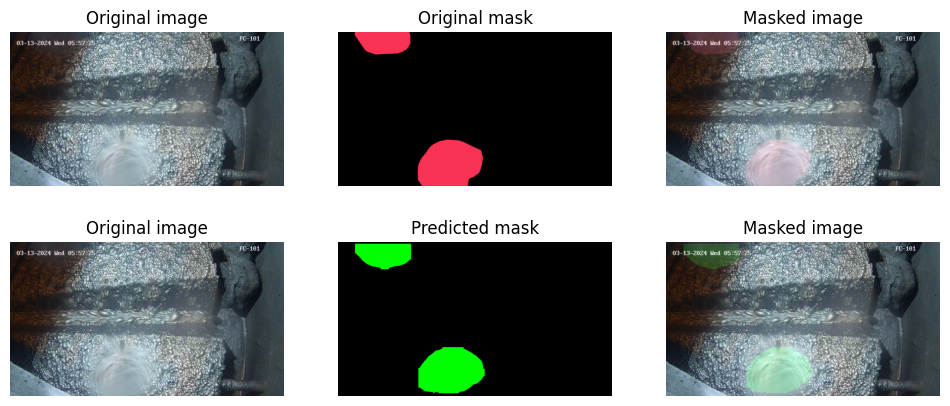

In [32]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

plt.subplot(2, 3, 1)  
plt.imshow(image)
plt.axis('off')  # Hide the axis labels
plt.title("Original image") 

plt.subplot(2, 3, 2)
plt.imshow(mask)
plt.axis('off')  # Hide the axis labels
plt.title("Original mask") 

masked_image = cv2.addWeighted(image, 1, mask, 0.15, 0)

plt.subplot(2, 3, 3)
plt.imshow(masked_image)
plt.axis('off')  # Hide the axis labels
plt.title("Masked image")

plt.subplot(2, 3, 4)  
plt.imshow(image)
plt.axis('off')  # Hide the axis labels
plt.title("Original image") 

rgb_mask = np.zeros_like(image)
rgb_mask[:,:,1] = mask_image

plt.subplot(2, 3, 5)
plt.imshow(rgb_mask)
plt.axis('off')  # Hide the axis labels
plt.title("Predicted mask") 

masked_image = cv2.addWeighted(image, 1, rgb_mask, 0.15, 0)

plt.subplot(2, 3, 6)
plt.imshow(masked_image)
plt.axis('off')  # Hide the axis labels
plt.title("Masked image")

plt.show()